# BERT Pre-trained based NER model

### Installing dependencies
- Transformers for BERT pre-trained model



In [1]:
#!pip install pandas transformers tensorflow scikit-learn

### Setup

In [2]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForTokenClassification
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import pandas as pd
from transformers import BertTokenizerFast
from transformers import TFBertModel
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [3]:
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, False)
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [
                    tf.config.experimental.VirtualDeviceConfiguration(
                        memory_limit=12288  # set your limit
                    )
                ],
            )
        tf.config.experimental.set_visible_devices(gpus[0], "GPU")
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

In [4]:

df = pd.read_csv("/content/dataset.csv", encoding="latin-1")
df.columns

Index(['sentence#', 'word', 'label'], dtype='object')

In [5]:
sentence = df.groupby("sentence#")["word"].apply(list).values
tag = df.groupby(by = 'sentence#')['label'].apply(list).values

In [6]:
df.sample(5)

,sentence#,word,label
4593,5763,Stij,Mountain
2371,5503,Hropa,Mountain
191,5234,Hora,O
1540,5392,the,O
1820,5427,and,O


In [7]:
def process_data(data_path):
    df = pd.read_csv(data_path, encoding="latin-1")

    enc_pos = preprocessing.LabelEncoder()
    enc_tag = preprocessing.LabelEncoder()

    df.loc[:, "label"] = enc_tag.fit_transform(df["label"])

    sentences = df.groupby("sentence#")["word"].apply(list).values
    tag = df.groupby("sentence#")["label"].apply(list).values
    return sentences, tag, enc_pos, enc_tag

sentence,tag,enc_pos,enc_tag = process_data("/content/dataset.csv")

<ipython-input-7-21a62ac50909>:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "label"] = enc_tag.fit_transform(df["label"])


In [8]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
MAX_LEN = 128

In [9]:
def tokenize(data, max_len=MAX_LEN):
    input_ids = list()
    attention_mask = list()
    for i in tqdm(range(len(data))):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens = True,
                                        max_length = MAX_LEN,
                                        is_split_into_words=True,
                                        return_attention_mask=True,
                                        padding = 'max_length',
                                        truncation=True,return_tensors = 'np')


        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
    return np.vstack(input_ids),np.vstack(attention_mask)

In [10]:
X_train,X_test,y_train,y_test = train_test_split(sentence,tag,random_state=42,test_size=0.1)
X_train.shape,X_test.shape,y_train.shape,y_test.shape
X_train.tolist()

[['Gora',
  'Kostyushki',
  'witnessed',
  'the',
  'beauty',
  'of',
  'Hora',
  'Kremenets'],
 ['Burlug', 'and', 'Legener', 'celebrated', 'in', 'joy'],
 ['Stih', 'whispered', 'secrets', 'to', 'Gora', 'Zadnya'],
 ['Hora',
  'Lautanska',
  'Holytsia',
  'danced',
  'with',
  'Hora',
  'Hostra',
  'Hora',
  'under',
  'the',
  'stars'],
 ['Hora', 'Studenets', 'and', 'Hora', 'Velyka', 'climbed', 'the', 'slopes'],
 ['Gora', 'Lungul', 'stood', 'tall', 'on', 'the', 'slopes', 'of', 'Lopushna'],
 ['Hora', 'Vydylok', 'danced', 'under', 'the', 'moonlight'],
 ['Stih', 'marveled', 'at', 'the', 'beauty', 'of', 'Gora', 'Zadnya'],
 ['Hora', 'Mahii', 'stood', 'tall', 'on', 'the', 'Hora', 'Kruhla', 'peak'],
 ['Gora', 'Beskid', 'and', 'Gora', 'Zhornina', 'watched', 'the', 'sunset'],
 ['Hora',
  'Tashly-Burun',
  'and',
  'Hora',
  'Livaz-Kaya',
  'celebrated',
  'the',
  'night',
  'away'],
 ['Gora', 'Gnutaya', 'and', 'Gora', 'Koshka', 'stood', 'side', 'by', 'side'],
 ['Gora', 'Zlobski', 'witnessed', '

In [11]:
input_ids,attention_mask = tokenize(X_train,max_len = MAX_LEN)

100%|██████████| 564/564 [00:00<00:00, 2418.06it/s]


In [12]:
val_input_ids,val_attention_mask = tokenize(X_test,max_len = MAX_LEN)

100%|██████████| 63/63 [00:00<00:00, 1861.95it/s]


# Test padding and truncation lenght

In [13]:
# TEST: Checking Padding and Truncation length's
was = list()
for i in range(len(input_ids)):
    was.append(len(input_ids[i]))
set(was)

{128}

In [14]:
# Train Padding
train_tag = list()
for i in range(len(y_train)):
    train_tag.append(np.array(y_train[i] + [0] * (128-len(y_train[i]))))

# TEST:  Checking Padding Length
was = list()
for i in range(len(train_tag)):
    was.append(len(train_tag[i]))
set(was)

{128}

In [15]:
# Train Padding
test_tag = list()
for i in range(len(y_test)):
    test_tag.append(np.array(y_test[i] + [0] * (128-len(y_test[i]))))

# TEST:  Checking Padding Length
was = list()
for i in range(len(test_tag)):
    was.append(len(test_tag[i]))
set(was)

{128}

# Building a model

In [16]:
# bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def create_model(bert_model,max_len = MAX_LEN):
    input_ids = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    attention_masks = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    bert_output = bert_model(input_ids,attention_mask = attention_masks,return_dict =True)
    embedding = tf.keras.layers.Dropout(0.3)(bert_output["last_hidden_state"])
    output = tf.keras.layers.Dense(17,activation = 'softmax')(embedding)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = [output])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [17]:
#with strategy.scope():
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
model = create_model(bert_model,MAX_LEN)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

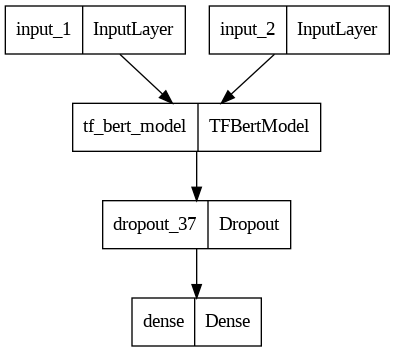

In [19]:
tf.keras.utils.plot_model(model)

# Training model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(mode='min',patience=5)
history_bert = model.fit([input_ids,attention_mask],np.array(train_tag),validation_data = ([val_input_ids,val_attention_mask],np.array(test_tag)),epochs = 25,batch_size = 30*2,callbacks = early_stopping,verbose = True)

Epoch 1/25


In [ ]:
model.save_weights("ner_bert_weights")

In [ ]:

import matplotlib.pyplot as plt
plt.plot(history_bert.history['accuracy'])
plt.plot(history_bert.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_bert.history['loss'])
plt.plot(history_bert.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def pred(val_input_ids,val_attention_mask):
    return model.predict([val_input_ids, val_attention_mask])

In [ ]:
def testing(val_input_ids, val_attention_mask, enc_tag, y_test):
    # Get the actual length of the sentence
    sentence_length = len(val_input_ids[val_input_ids > 0])

    # Reshape the arrays to match the sentence length
    val_input = val_input_ids[:sentence_length].reshape(1, sentence_length)
    val_attention = val_attention_mask[:sentence_length].reshape(1, sentence_length)

    # Print Original Sentence
    sentence = tokenizer.decode(val_input_ids[val_input_ids > 0])
    print("Original Text : ",str(sentence))
    print("\n")
    true_enc_tag = enc_tag.inverse_transform(y_test)

    print("Original Tags : " ,str(true_enc_tag))
    print("\n")

    prediction = pred(val_input,val_attention)
    pred_with_pad = np.argmax(prediction, axis=-1)
    print(prediction)
    print(pred_with_pad)
    pred_without_pad = pred_with_pad[pred_with_pad != 0]  # Assuming padding token is 0
    pred_enc_tag = enc_tag.inverse_transform(pred_without_pad)

    print("Predicted Tags : ",pred_enc_tag)
# Example usage
index = 0
testing(val_input_ids[index], val_attention_mask[index], enc_tag, y_test[index])